## Digit Recognizer

In [51]:
import time
import keras.optimizers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import f1_score
from keras.wrappers.scikit_learn import KerasClassifier

In [52]:
X = np.load("MNIST-images.npy")
y = np.load("MNIST-labels.npy")

In [53]:
seed = 234

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed
)
# Getting familiar with the dataset
print("X_train: ",len(X_train), X_train.shape)
print("X_test: ",len(X_test), X_test.shape)

X_train:  59691 (59691, 24, 24, 1)
X_test:  25582 (25582, 24, 24, 1)


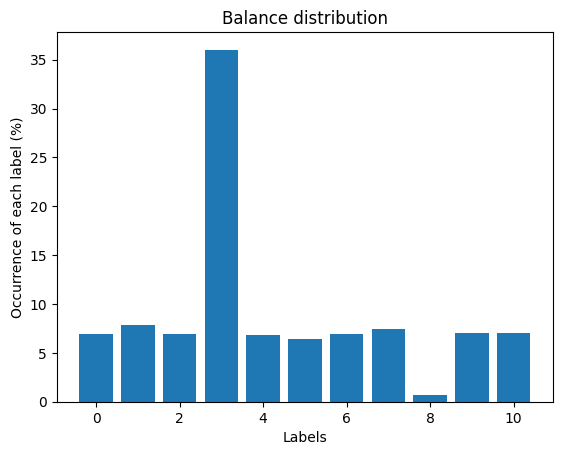

[(0, 4123), (1, 4714), (2, 4113), (3, 21503), (4, 4060), (5, 3825), (6, 4116), (7, 4429), (8, 424), (9, 4193), (10, 4191)]


In [54]:
def plot_balance(y):
    labels, counts = np.unique(y, return_counts=True)
    plt.bar(labels,(counts/y.size)*100)
    plt.xlabel("Labels")
    plt.ylabel("Occurrence of each label (%)")
    plt.title("Balance distribution")
    plt.show()
    print(list(zip(labels, counts)))
plot_balance(y_train)

9
[ 2  4  4  4  9  6  3  3  0  3  3  0  9  2  6 10  5  3  7  3  3  3  6  3
  2  3  3  1  9  7  9  3  9  3  9]


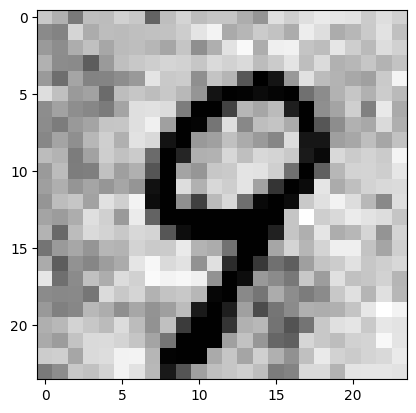

In [55]:
img_index = 34
print(y_train[img_index])
print(y_train[:img_index +1])
plt.imshow(X_train[img_index], cmap="Greys")
plt.show()

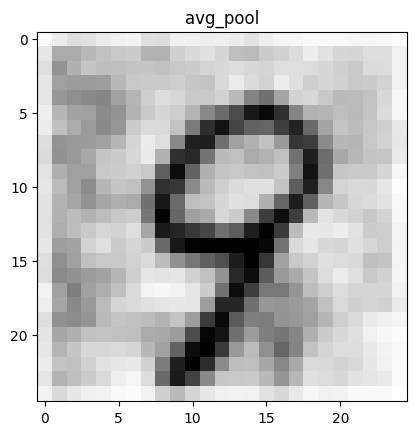

In [56]:
from torch.nn.functional import avg_pool2d
import torch

# Smooths out the images
def avg_pool(imgs, kernel_size = (2, 2), padding = 1, stride = 1):
    imgs = imgs.reshape(imgs.shape[0], imgs.shape[1], imgs.shape[2])
    imgs = torch.tensor(imgs).to(torch.long)
    return avg_pool2d(imgs, kernel_size = kernel_size, stride=stride, padding=padding).unsqueeze(-1).numpy()

# Show an image to visualize the pooling
pooling_test = avg_pool(X_train)
test_img = pooling_test[img_index]
plt.imshow(test_img, cmap="Greys")
plt.title("avg_pool")
plt.show()

9
[ 2  4  4  4  9  6  3  3  0  3  3  0  9  2  6 10  5  3  7  3  3  3  6  3
  2  3  3  1  9  7  9  3  9  3  9]
(85273, 24, 24, 1)


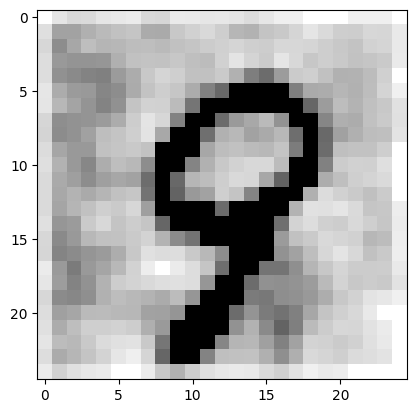

In [57]:
def preprocess(X):
    X = avg_pool(X)
    for i in range(X.shape[0]):
        pix = X[i,:,:,0] < 30
        X[i,pix] = 0
        pix = X[i,:,:,0] > 175
        X[i,pix] = 255

    X= X / 255
    return X

X_train = preprocess(X_train)
X_test = preprocess(X_test)

def flatten_imgs(X):
    return X.reshape(-1, X.shape[1]*X.shape[1])

img_index = 34
print(y_train[img_index])
print(y_train[:img_index +1])
plt.imshow(X_train[img_index], cmap="Greys")
print(X.shape)

4D:  (59691, 25, 25, 1)
2D:  (59691, 625)


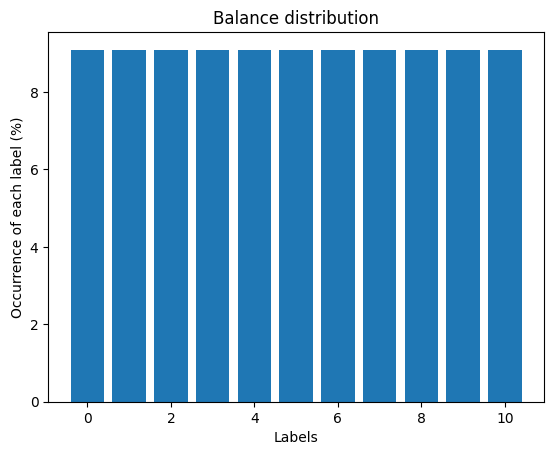

[(0, 21503), (1, 21503), (2, 21503), (3, 21503), (4, 21503), (5, 21503), (6, 21503), (7, 21503), (8, 21503), (9, 21503), (10, 21503)]


In [58]:
from imblearn.over_sampling import SMOTE
print("4D: ",X_train.shape)
X_train = flatten_imgs(X_train)
print("2D: ",X_train.shape)
X_test = flatten_imgs(X_test)
smote = SMOTE(random_state=seed)#, sampling_strategy="minority")
X_train, y_train = smote.fit_resample(X_train, y_train)
plot_balance(y_train)

In [59]:
from sklearn.decomposition  import PCA
# Create a copy for CNN to avoid PCA without
X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN = np.copy(X_train), np.copy(X_test), np.copy(y_train), np.copy(y_test)
pca = PCA(n_components=65)
print(X_train.shape)
print(X_test.shape)
X_train = pca.fit_transform(X_train)
print(X_train.shape)
X_test = pca.transform(X_test)
print(X_test.shape)

(236533, 625)
(25582, 625)
(236533, 65)
(25582, 65)


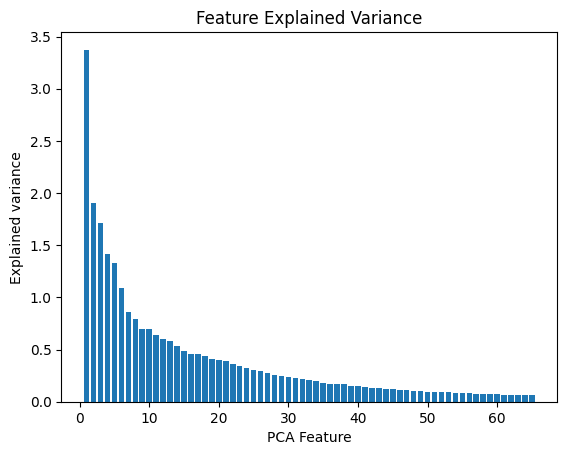

In [60]:
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
)
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

Text(0.5, 0.85, '95% cut-off threshold')

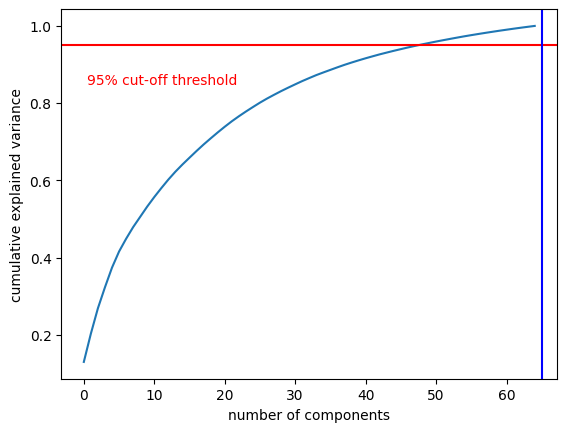

In [61]:
pca = PCA().fit(X_train.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.axvline(x = 65, color = 'b', label = 'axvline - full height')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=10)

In [62]:
# save the best models
best_models = {}
print(X_train_CNN.shape)

(236533, 625)


In [ ]:
from keras.utils import to_categorical
import math
# image dimensions
pixel_quad = int(math.sqrt(X_train_CNN.shape[1]))
num_classes = 11

# reshape the format to (M * N * 1) to work with keras
X_train_CNN = X_train_CNN.reshape(X_train_CNN.shape[0], pixel_quad, pixel_quad, 1)
X_test_CNN = X_test_CNN.reshape(X_test_CNN.shape[0], pixel_quad, pixel_quad, 1)
y_train_CNN = to_categorical(y_train_CNN, num_classes)

In [72]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras import callbacks

start = time.time()
name = "CNN"

#y_test = to_categorical(y_test, num_classes)

def create_model(learning_rate = 0.01, n_layers=3):
    print("n_layers: ", n_layers)
    # creates an empty model object
    model = Sequential()
    # add the first convolutional layer with relu (rectified linear units) activation
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(pixel_quad, pixel_quad, 1)))
    # pooling after each level reduces the spatial dimensions
    model.add(MaxPooling2D(pool_size=(2,2)))

    # add the rest of the convolutional layers
    for i in range(n_layers-1):
        # for each layer, increase the number of filters by 64*2^i --> [64, 128, 256, 512...., 2^n]
        model.add(Conv2D(64*(2**(i)), (3,3), activation='relu'))
        #print(64*(2**(i)))
    model.add(MaxPooling2D(pool_size=(3,3)))
    # randomly drop 25% of the units to avoid overfitting
    model.add(Dropout(0.25))
    # convert hidden layer to 1D array
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    # add Dense layer to classify the data
    model.add(Dense(num_classes, activation="softmax"))
    opt= keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss="categorical_crossentropy",
                  optimizer=opt,
                  metrics=["accuracy"])
    return model

# model class for scikit randomized grid search
model = KerasClassifier(build_fn=create_model, epochs=15)

layers = [2, 3]
learning_rate = [1e-2, 1e-3]#, 1e-4]

param_grid = dict(
    learning_rate = learning_rate,
    n_layers = layers,
)

cv = RandomizedSearchCV(estimator=model,
                        param_distributions=param_grid,
                        scoring="f1_micro", verbose=20, n_iter=2, n_jobs=-1, cv=KFold(2), random_state=seed)

early_stopping = callbacks.EarlyStopping(monitor="loss",
                                         mode="min",
                                         patience=5,
                                         restore_best_weights=True)

CNN_result = cv.fit(X_train_CNN,
                    y_train_CNN,
                    batch_size=128,
                    verbose=1,
                    callbacks=[early_stopping])

CNN_results_df = pd.DataFrame(CNN_result.cv_results_)
CNN_results_df.to_csv('gridsearch.csv')
display(CNN_results_df)
print(CNN_result.best_params_)
print("Best score: ", CNN_result.best_score_)
print("Duration: CNN Training and Cross-validation ", (time.time() - start), " Minutes")

CNN_best_score = CNN_result.best_score_
CNN_best_estimator = CNN_result.best_estimator_
best_models[name] = [CNN_best_estimator, CNN_best_score]

C:\Users\mef015\AppData\Local\Temp\ipykernel_18384\3091921340.py:41: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=15)


Fitting 2 folds for each of 2 candidates, totalling 4 fits


C:\Users\mef015\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


n_layers:  2
Epoch 1/15
1848/1848 [==============================] - 63s 34ms/step - loss: 0.2352 - accuracy: 0.9256
Epoch 2/15
1848/1848 [==============================] - 58s 31ms/step - loss: 0.0670 - accuracy: 0.9795
Epoch 3/15
1848/1848 [==============================] - 57s 31ms/step - loss: 0.0493 - accuracy: 0.9847
Epoch 4/15
1848/1848 [==============================] - 64s 35ms/step - loss: 0.0399 - accuracy: 0.9877
Epoch 5/15
1848/1848 [==============================] - 66s 36ms/step - loss: 0.0348 - accuracy: 0.9891
Epoch 6/15
1677/1848 [==========================>...] - ETA: 5s - loss: 0.0304 - accuracy: 0.9904


KeyboardInterrupt



In [71]:
print(X_train_CNN.shape)
print(y_train_CNN)

(236533, 25, 25, 1)
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


# KNN-classifier

In [64]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

name = "KNN"
start_time = time.time()
KNN_model = KNeighborsClassifier(n_neighbors=4, leaf_size=30, n_jobs=3)
kf = StratifiedKFold(n_splits=5)

k = [1, 2, 3, 4]
leaf_size = [20, 30, 40, 50]
n_jobs = [None, 3, 5, -1]

params = dict(
    n_neighbors = k,
    n_jobs = n_jobs,
    leaf_size = leaf_size
)

cv = RandomizedSearchCV(estimator=KNN_model,
                        param_distributions=params,scoring="f1_micro",verbose=5, n_iter=6, n_jobs=-1, cv=kf, random_state=seed, refit=True)



KNN_result = cv.fit(X_train, y_train)

KNN_results_df = pd.DataFrame(KNN_result.cv_results_)
KNN_results_df.to_csv('gridsearch_KNN.csv')
display(KNN_results_df)
print(KNN_result.best_params_)
print("Duration: KNN Training and Cross-validation", (time.time()-start_time)/60, " Minutes")
print("Best score: ", KNN_result.best_score_)

KNN_best_score = KNN_result.best_score_
KNN_best_estimator = KNN_result.best_estimator_

best_models[name] = [KNN_best_estimator, KNN_best_score]


Fitting 5 folds for each of 6 candidates, totalling 30 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_n_jobs,param_leaf_size,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.149070,0.011713,144.823094,3.687843,3,-1,30,"{'n_neighbors': 3, 'n_jobs': -1, 'leaf_size': 30}",0.972309,0.974993,0.974930,0.974337,0.974570,0.974228,0.000989,4
1,0.137548,0.024425,153.994159,8.820869,3,5,40,"{'n_neighbors': 3, 'n_jobs': 5, 'leaf_size': 40}",0.972309,0.974993,0.974930,0.974337,0.974570,0.974228,0.000989,4
2,0.180580,0.010972,165.760424,2.096941,3,3,20,"{'n_neighbors': 3, 'n_jobs': 3, 'leaf_size': 20}",0.972309,0.974993,0.974930,0.974337,0.974570,0.974228,0.000989,4
3,0.205446,0.035939,152.083152,7.011474,2,None,30,"{'n_neighbors': 2, 'n_jobs': None, 'leaf_size'...",0.977678,0.980045,0.980679,0.979876,0.980446,0.979745,0.001072,1
4,0.198717,0.034290,144.570207,13.768898,2,None,20,"{'n_neighbors': 2, 'n_jobs': None, 'leaf_size'...",0.977678,0.980045,0.980679,0.979876,0.980446,0.979745,0.001072,1
5,0.189679,0.018723,114.975813,0.441293,1,-1,20,"{'n_neighbors': 1, 'n_jobs': -1, 'leaf_size': 20}",0.977720,0.979390,0.979136,0.979559,0.979537,0.979068,0.000691,3


{'n_neighbors': 2, 'n_jobs': None, 'leaf_size': 30}
Duration: KNN Training and Cross-validation 9.670841228961944  Minutes
Best score:  0.9797449016938629


## MLP

In [75]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5)
name = "MLP"
start_time_mlp = time.time()

MLP_model = MLPClassifier(hidden_layer_sizes=(100,),
                          alpha=0.0001,
                          verbose=1,
                          random_state=seed,
                          learning_rate_init=0.1)

params = dict(
    learning_rate_init = [0.01, 1e-2, 1e-3],
    hidden_layer_sizes = [(128, 128), (64,32), (32,16)] #576, 288, 1)]#, (64, 128, 256), (576, 292, 128, 9)] #(50,20,10)

)

cv = RandomizedSearchCV(estimator=MLP_model,
                        param_distributions=params,
                        scoring="f1_micro",
                        verbose=5,
                        n_iter=6,
                        n_jobs=-1,
                        cv=kf,
                        random_state=seed,
                        refit=True)

MLP_result = cv.fit(X_train, y_train)

MLP_result_df = pd.DataFrame(MLP_result.cv_results_)
MLP_result_df.to_csv('gridsearch_MLP.csv')
display(MLP_result_df)
print(MLP_result.best_params_)
print("Best score: ", MLP_result.best_score_)

print("Duration: MLP Training and Cross-validation", (time.time()-start_time_mlp)/60, " Minutes")

MLP_best_score = MLP_result.best_score_
MLP_best_estimator = MLP_result.best_estimator_

best_models[name] = [MLP_best_estimator, MLP_best_score]


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Iteration 1, loss = 0.24737852
Iteration 2, loss = 0.07055254
Iteration 3, loss = 0.04603666
Iteration 4, loss = 0.03347821
Iteration 5, loss = 0.02538770
Iteration 6, loss = 0.01993674
Iteration 7, loss = 0.01571336
Iteration 8, loss = 0.01329412
Iteration 9, loss = 0.01079074
Iteration 10, loss = 0.00920257
Iteration 11, loss = 0.00801482
Iteration 12, loss = 0.00683283
Iteration 13, loss = 0.00618312
Iteration 14, loss = 0.00622632
Iteration 15, loss = 0.00466140
Iteration 16, loss = 0.00534546
Iteration 17, loss = 0.00403468
Iteration 18, loss = 0.00476647
Iteration 19, loss = 0.00453370
Iteration 20, loss = 0.00369522
Iteration 21, loss = 0.00334762
Iteration 22, loss = 0.00437614
Iteration 23, loss = 0.00308292
Iteration 24, loss = 0.00385048
Iteration 25, loss = 0.00320915
Iteration 26, loss = 0.00395894
Iteration 27, loss = 0.00272217
Iteration 28, loss = 0.00382269
Iteration 29, loss = 0.00308980
Iteration 30, loss = 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate_init,param_hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,190.939994,79.363529,0.709346,0.326560,0.01,"(128, 128)","{'learning_rate_init': 0.01, 'hidden_layer_siz...",0.979390,0.992327,0.993870,0.993553,0.994187,0.990665,0.005673,2
1,136.395432,23.283982,0.108905,0.010660,0.01,"(32, 16)","{'learning_rate_init': 0.01, 'hidden_layer_siz...",0.948697,0.974591,0.976473,0.978946,0.980320,0.971805,0.011722,6
2,205.033085,53.125983,0.364723,0.063233,0.001,"(128, 128)","{'learning_rate_init': 0.001, 'hidden_layer_si...",0.974359,0.995857,0.996428,0.995519,0.996681,0.991769,0.008714,1
3,141.390950,43.116051,0.228141,0.039768,0.01,"(64, 32)","{'learning_rate_init': 0.01, 'hidden_layer_siz...",0.970152,0.989346,0.988670,0.988289,0.989811,0.985254,0.007569,5
4,274.635695,30.643561,0.114854,0.038562,0.001,"(64, 32)","{'learning_rate_init': 0.001, 'hidden_layer_si...",0.972964,0.992897,0.993785,0.992897,0.992792,0.989067,0.008060,4
5,156.640473,49.846263,0.440454,0.191612,0.01,"(128, 128)","{'learning_rate_init': 0.01, 'hidden_layer_siz...",0.979390,0.992327,0.993870,0.993553,0.994187,0.990665,0.005673,2


{'learning_rate_init': 0.001, 'hidden_layer_sizes': (128, 128)}
Best score:  0.991768627051899
Duration: MLP Training and Cross-validation 14.804939333597819  Minutes


In [67]:
from sklearn.ensemble import RandomForestClassifier
name = "RF"
start_time_RF = time.time()

RFC_model = RandomForestClassifier(n_estimators=100,
                                   criterion="gini",
                                   random_state=seed)

params = dict(
    n_estimators = [50, 100, 150],
    criterion = ["gini", "entropy"]
)

cv = RandomizedSearchCV(estimator=RFC_model,
                        param_distributions=params,
                        scoring="f1_micro",
                        verbose=5,
                        n_iter=6,
                        n_jobs=-1,
                        cv=kf, random_state=seed,
                        refit=True)

RF_result = cv.fit(X_train, y_train)

cv_results_df = pd.DataFrame(RF_result.cv_results_)
cv_results_df.to_csv('gridsearch_RFC.csv')
display(cv_results_df)
print(RF_result.best_params_)
print("Best score: ", RF_result.best_score_)

print("Duration: RFC Training and Cross-validation", (time.time()-start_time_RF)/60, " Minutes")

RF_best_score = RF_result.best_score_
RF_best_estimator = RF_result.best_estimator_

best_models[name] = [RF_best_estimator, RF_best_score]

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,279.186611,6.871781,1.105680,0.095163,50,gini,"{'n_estimators': 50, 'criterion': 'gini'}",0.979179,0.986873,0.987000,0.987253,0.986957,0.985452,0.003139,5
1,685.559469,45.490707,2.864390,0.359702,100,gini,"{'n_estimators': 100, 'criterion': 'gini'}",0.981821,0.988649,0.989473,0.988775,0.989135,0.987570,0.002889,2
2,1073.953183,24.500742,4.440478,0.781649,150,gini,"{'n_estimators': 150, 'criterion': 'gini'}",0.982814,0.989240,0.989748,0.989557,0.989663,0.988205,0.002701,1
3,762.660098,45.617070,1.162955,0.121608,50,entropy,"{'n_estimators': 50, 'criterion': 'entropy'}",0.976980,0.984738,0.985858,0.986302,0.985203,0.983816,0.003460,6
4,1332.495628,21.828176,2.340872,0.151971,100,entropy,"{'n_estimators': 100, 'criterion': 'entropy'}",0.979327,0.986915,0.987401,0.987443,0.986936,0.985605,0.003147,4
5,1711.550281,169.232977,2.454030,0.429230,150,entropy,"{'n_estimators': 150, 'criterion': 'entropy'}",0.980045,0.987634,0.987845,0.988310,0.987866,0.986340,0.003155,3


{'n_estimators': 150, 'criterion': 'gini'}
Best score:  0.9882046175846909
Duration: RFC Training and Cross-validation 80.79524530967076  Minutes


In [76]:
current_best_score = 0
current_best_estimator = ""
current_best_model = ""

for name, model in best_models.items():
    if np.isnan(model[1]):
        continue
    print(f"Name: {name} | Validation f1_score: {model[1]}")
    if model[1] > current_best_score:
        current_best_estimator = model[0]
        current_best_model = name
        current_best_score = model[1]

if current_best_model == "CNN":
    X_test = X_test_CNN
    y_test = y_test_CNN

best_model_pred = current_best_estimator.predict(X_test)
best_model_score = f1_score(y_test, best_model_pred, average = "micro")
print("-------------------BEST MODEL-------------------")
print(f"The best model on validation was {current_best_model}\n"
      f"f1_score for {current_best_model} on unseen data is: {best_model_score}")






Name: KNN | Validation f1_score: 0.9797449016938629
Name: RF | Validation f1_score: 0.9882046175846909
Name: MLP | Validation f1_score: 0.991768627051899
-------------------BEST MODEL-------------------
The best model on validation was MLP
f1_score for MLP on unseen data is: 0.9602063951215698
